In [4]:
import numpy as np
import matplotlib.pyplot as plt
# Inline plots
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# A little config for image plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.aspect'] = 'equal'
plt.rcParams['figure.figsize'] = [4, 2.5]

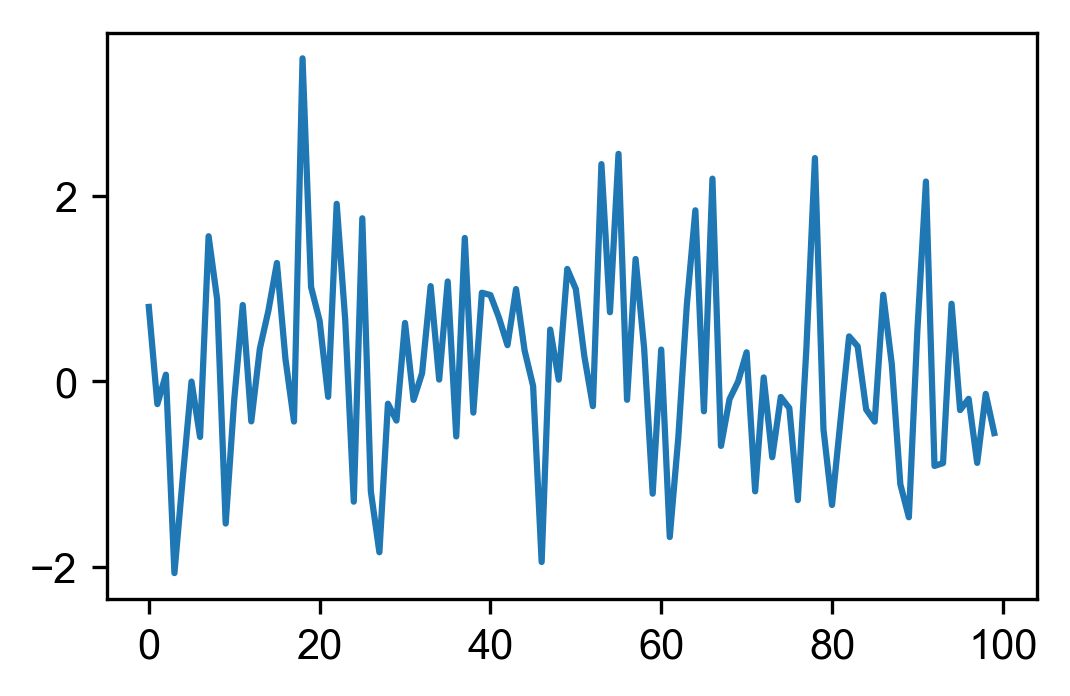

In [5]:
# Generate some noise data
n_timepoints = 100
data = np.random.randn(n_timepoints,)
fig, ax = plt.subplots()
_ = ax.plot(data)

1.0


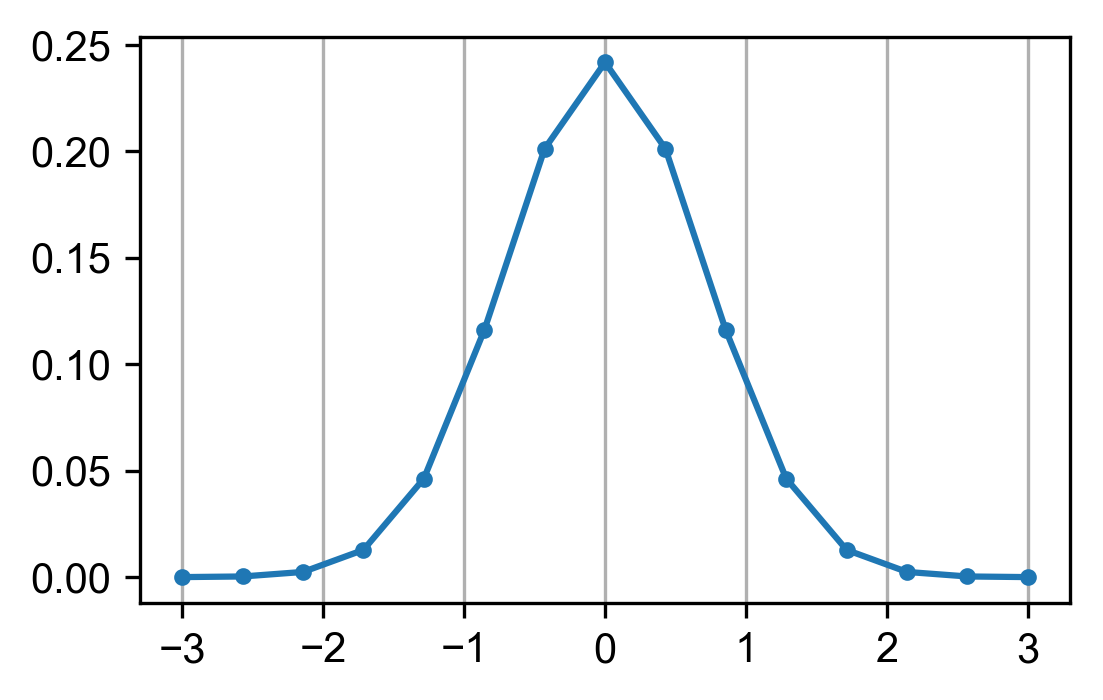

In [6]:
# Generate a gaussian smoothing kernel
n_c = 15
n_ = np.floor(n_c/2).astype(np.int)
x = np.linspace(-3, 3, n_c)
g = np.e**(-x**2)
g /= np.sum(g)
print(np.sum(g))
plt.plot(x,g, '.-')
plt.grid(axis='x')

# 1D convolution

In [7]:
# Help!
np.convolve?

True
(100,)


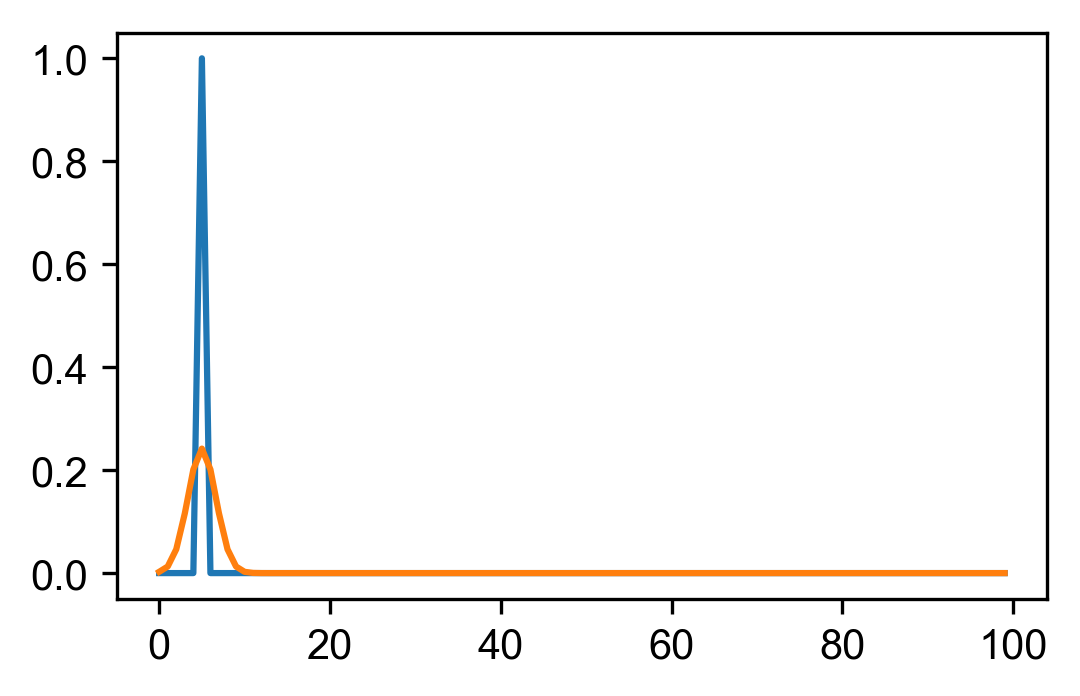

In [36]:
# Simple case
s = np.zeros((100,))
s[5] = 1
s_c = np.convolve(s, g, mode='same')
s_c2 = np.convolve(s, g, mode='full')
s_c2 = s_c2[n_:-n_]
print(np.allclose(s_c2, s_c))
print(s_c.shape)
plt.plot(s);
plt.plot(s_c);

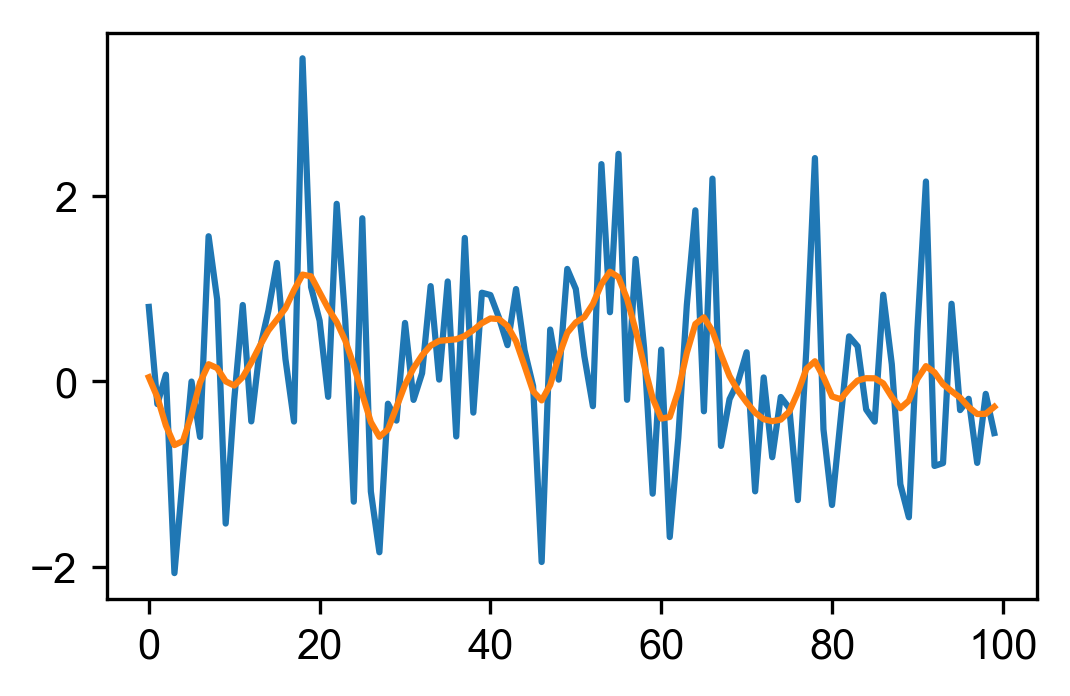

In [8]:
data_c = np.convolve(data, g, mode='full')
n_ = np.floor(n_c/2).astype(np.int)
data_c = data_c[n_:-n_]
plt.plot(data, label='original')
plt.plot(data_c, label='smoothed')

# 2D data

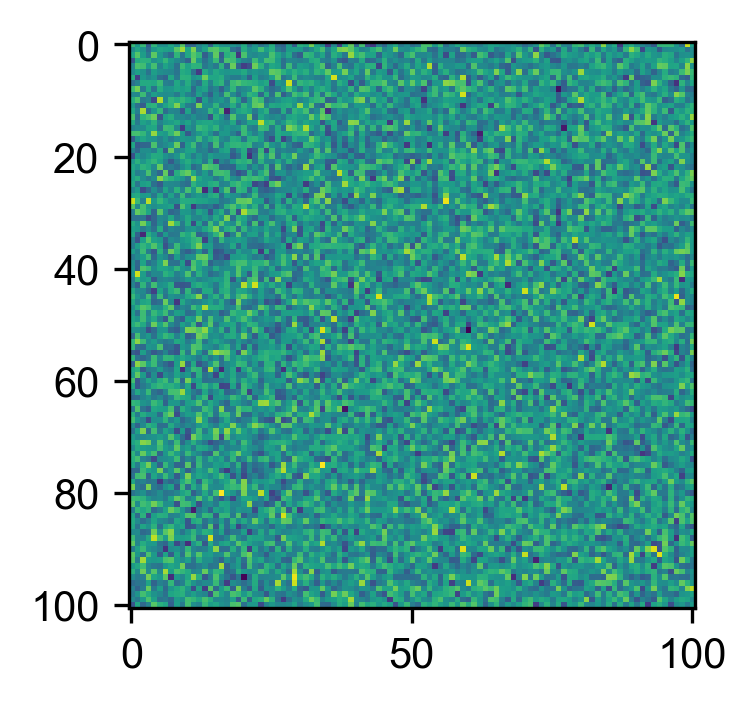

In [9]:
dims = [101, 101]
data2d = np.random.randn(*dims)
plt.imshow(data2d);

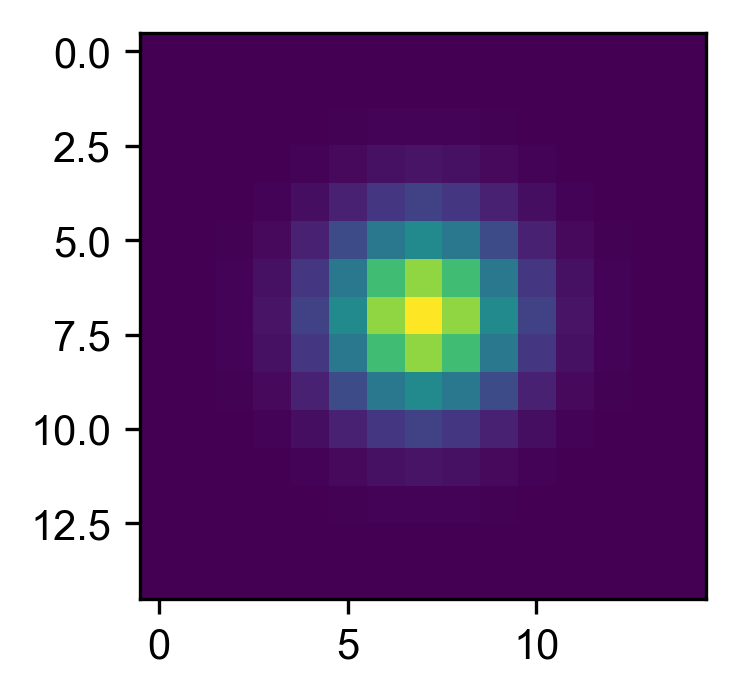

In [10]:
# 2D gaussian kernel
n_c = 15
t = np.linspace(-3, 3, n_c)
x, y = np.meshgrid(t, t)
g2d = np.e**(-(x**2+y**2))
g2d /= np.sum(g2d)
plt.imshow(g2d);

# 2D convolution

In [11]:
# Not in the same library, because python.
from scipy.signal import convolve2d

(101, 101)


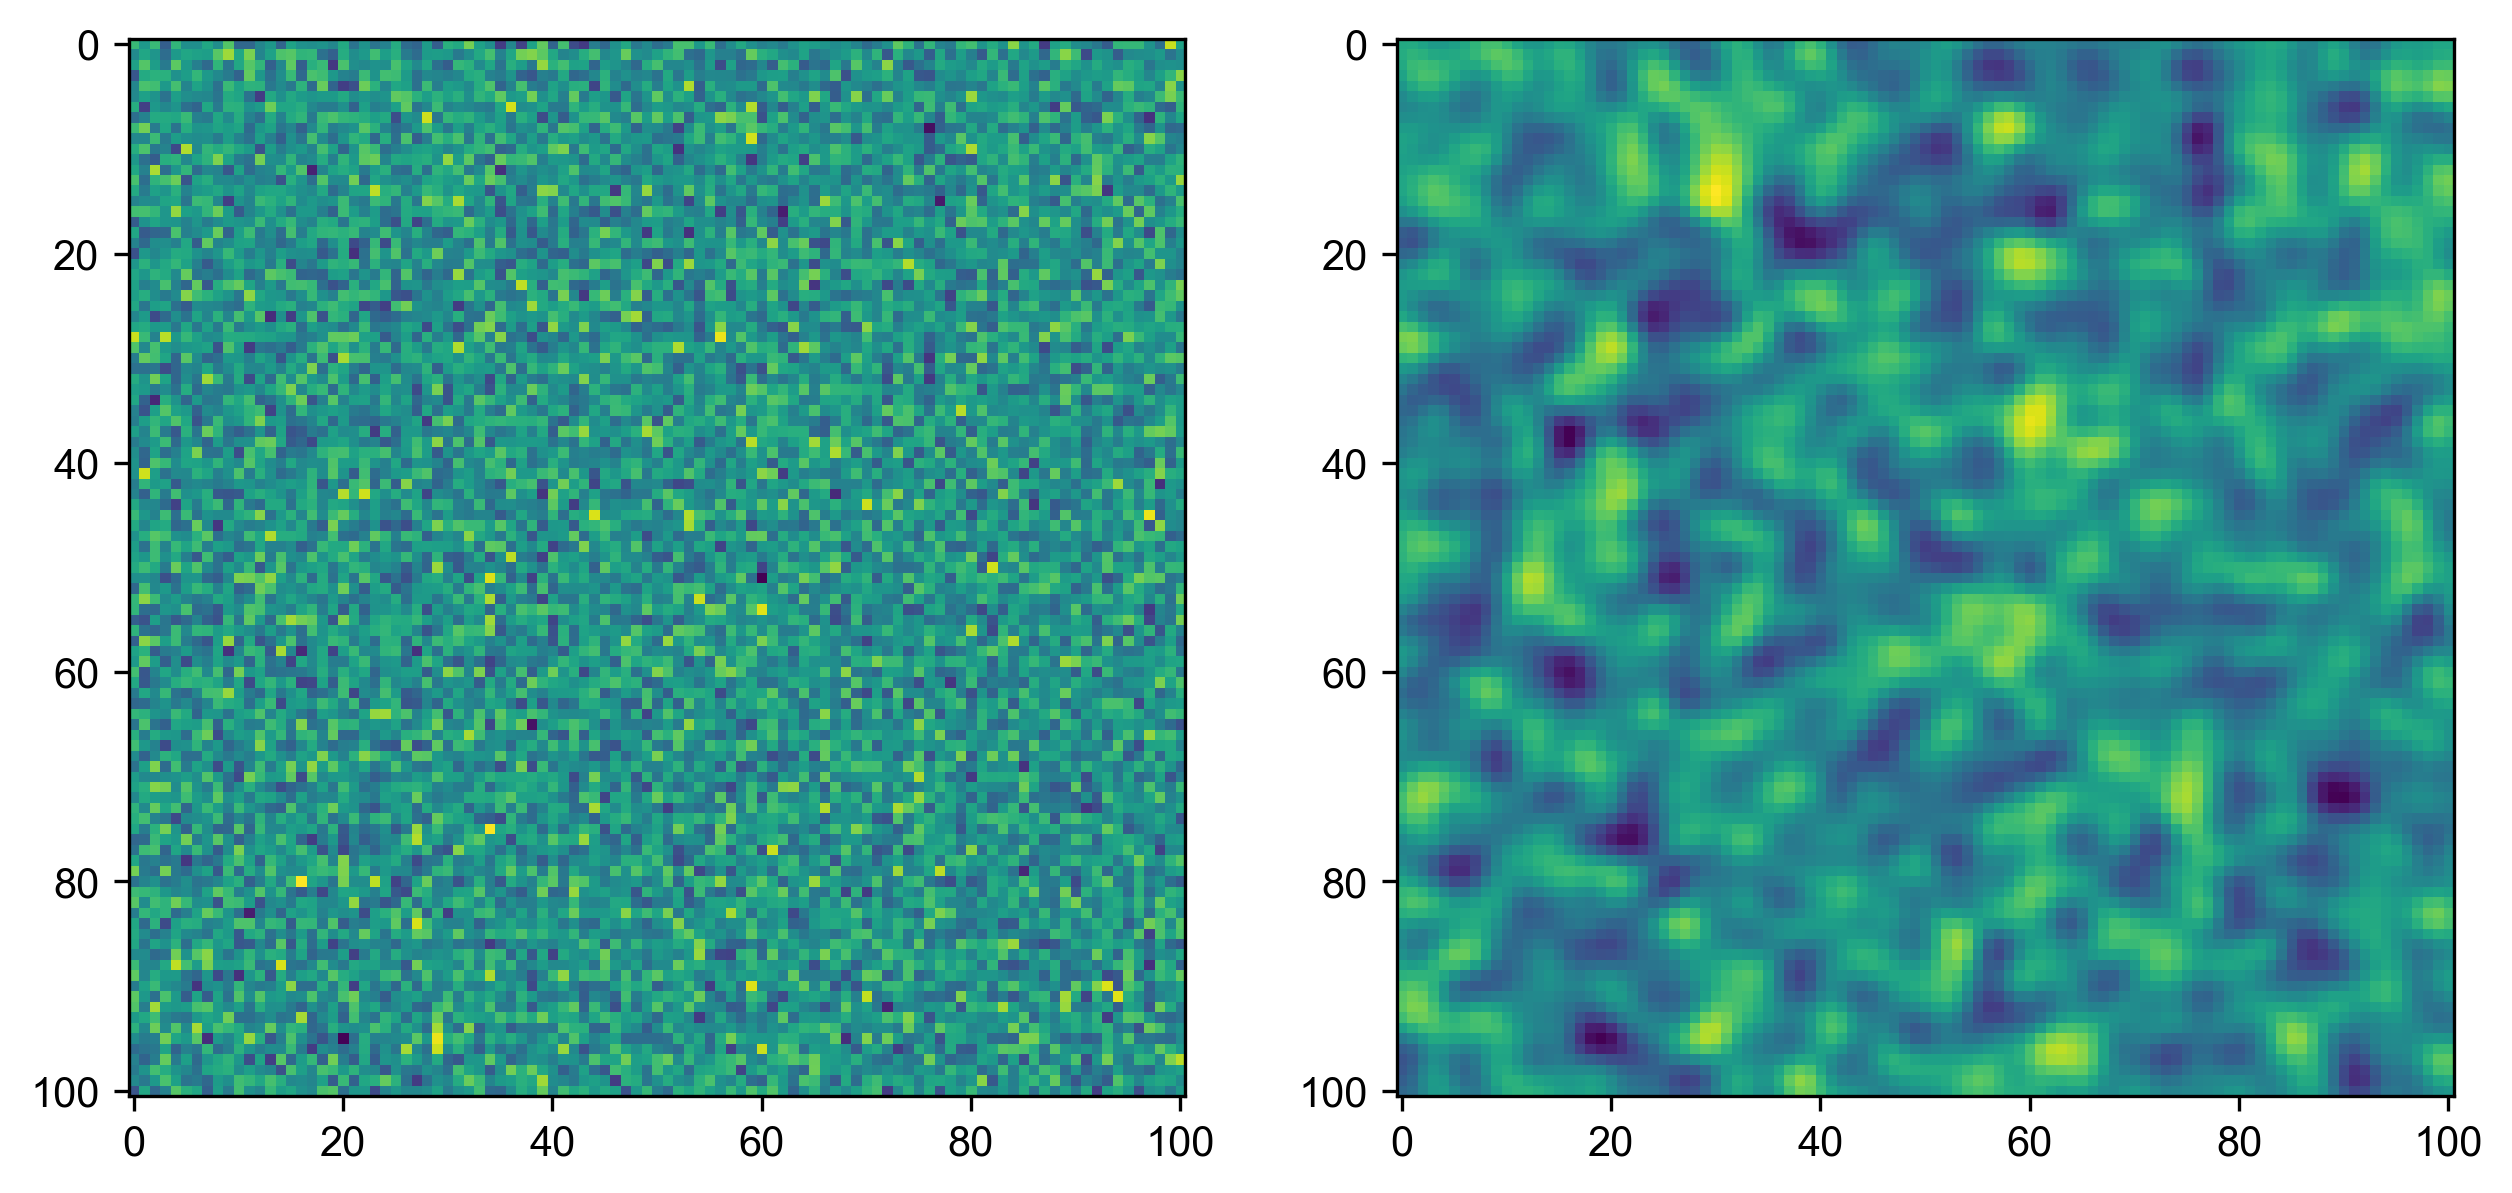

In [12]:
data2d_c = convolve2d(data2d, g2d, mode='full')
n_ = np.floor(n_c/2).astype(np.int)
data2d_c = data2d_c[n_:-n_, n_:-n_]
print(data2d_c.shape)
fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].imshow(data2d);
axs[1].imshow(data2d_c);

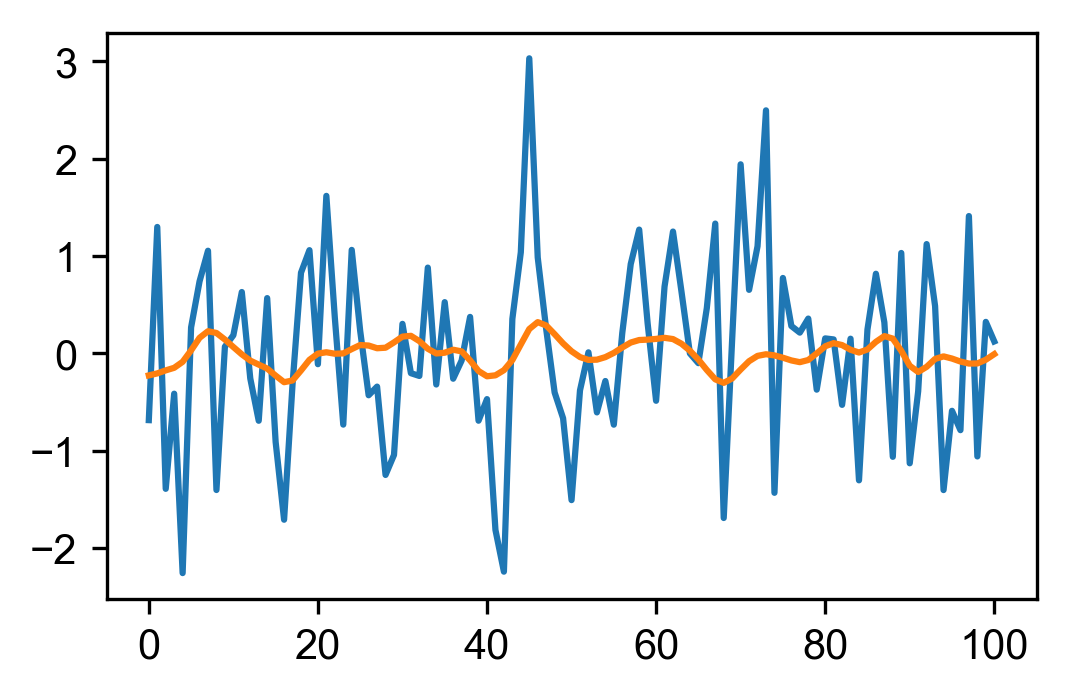

In [13]:
# Zoom on one line for a closer look
plt.plot(data2d[:,44])
plt.plot(data2d_c[:,44])

# Gamma function

# $h(t) = \frac{(t/\tau)^{n-1}e^{-t/\tau}}{\tau(n-1)!}$

$t$ is time

$\tau$ is time constant

$n$ is delay

In [14]:
from scipy.misc import factorial

def gammafun(t, tau, n):
    num = (t/tau)**(n-1) * np.e**(-t/tau)
    denom = tau*factorial(n-1)
    return num/denom

In [20]:
%matplotlib inline
from ipywidgets import interactive
#import matplotlib.pyplot as plt
#import numpy as np

def gamma_plot(tau, n):
    plt.figure(33, figsize=(3,2))
    t = np.linspace(0, 32, 100) # 32 seconds worth
    plt.plot(t, gammafun(t, tau, n))
    plt.ylim(-0.01, 0.10)
    plt.show()

interactive_plot = interactive(gamma_plot, tau=(1.0, 6.0, 1.0), n=(0.0, 6.0, 0.5))
#output = interactive_plot.children[-1]
#output.layout.height = '350px'
#interactive_plot

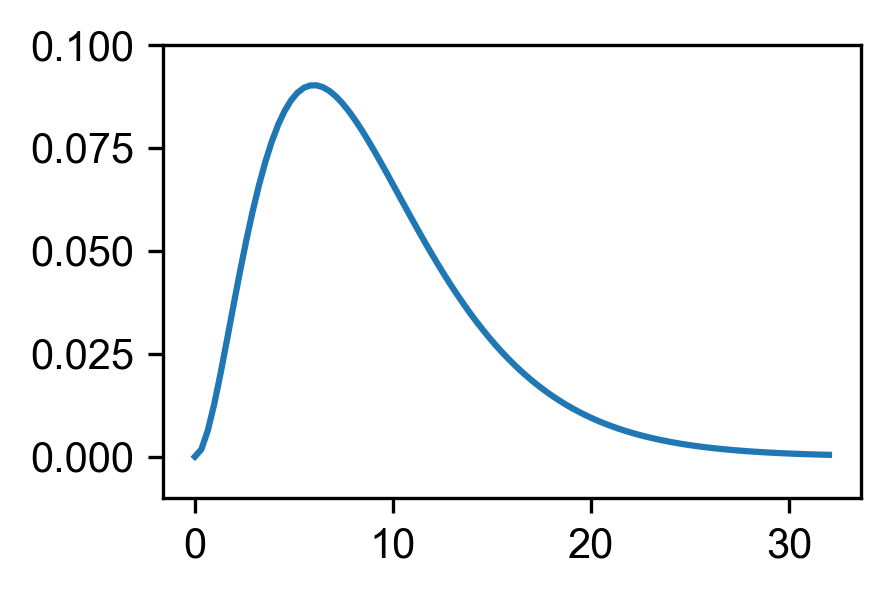

In [21]:
interactive_plot

In [17]:
interactive_plot.close()

In [47]:
import ipywidgets
ipywidgets.__version__

'7.1.1'

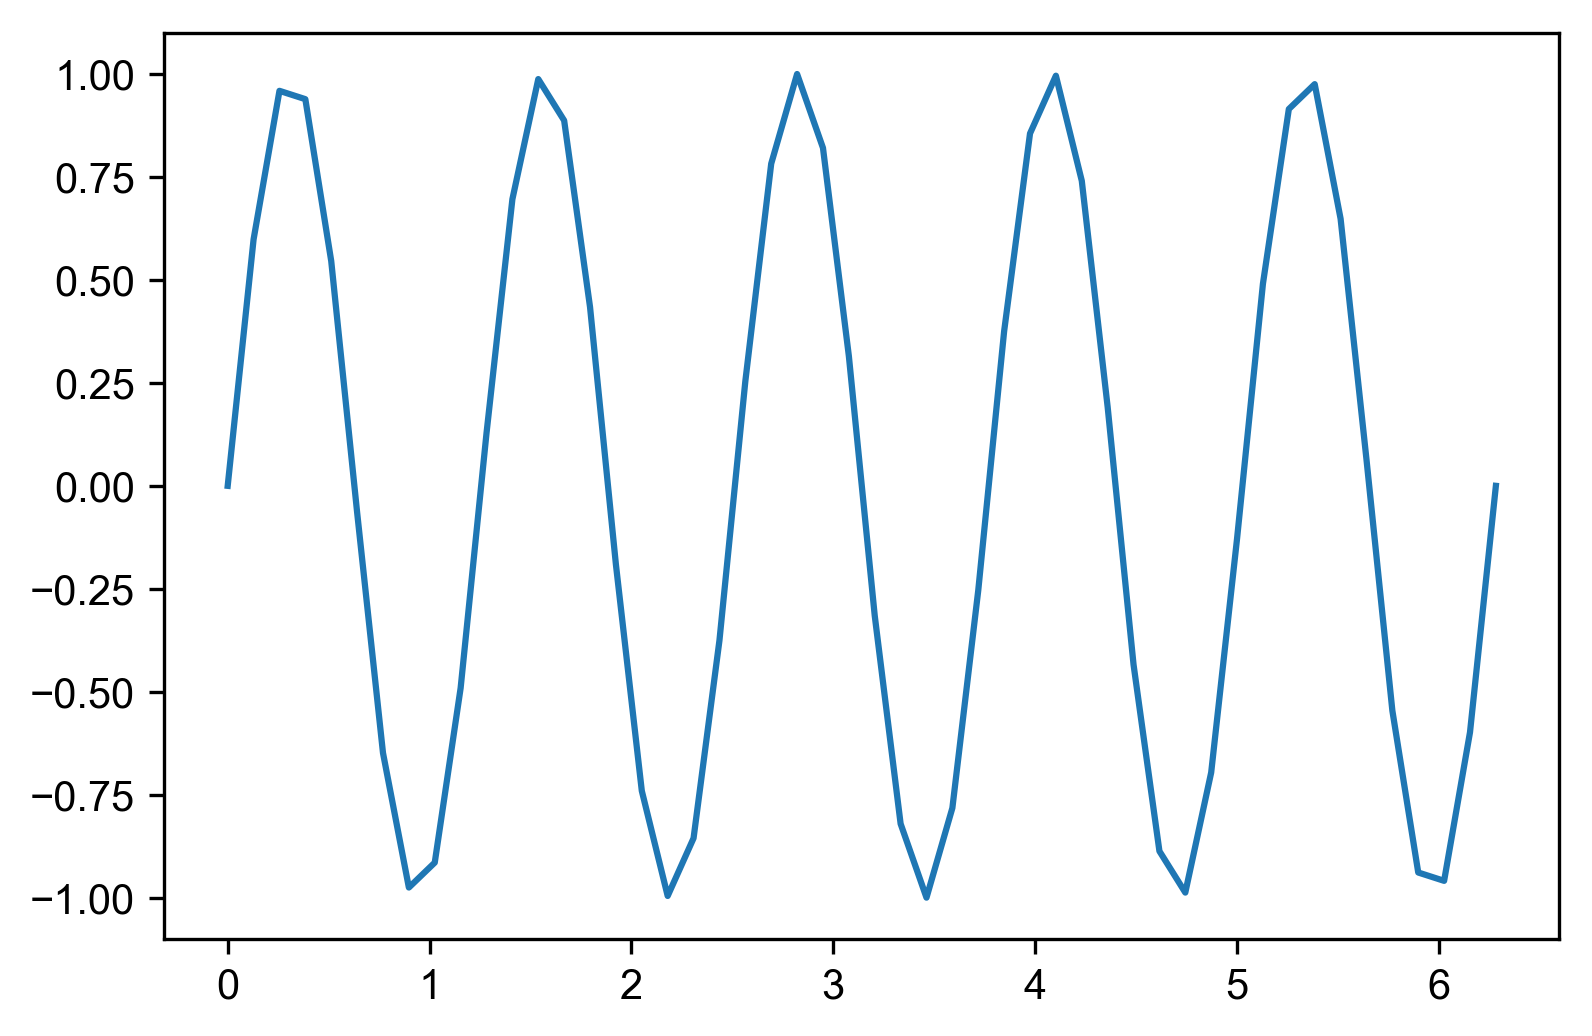

<function __main__.plot_func>

In [51]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

def plot_func(freq):
    x = np.linspace(0, 2*np.pi)
    y = np.sin(x * freq)
    plt.plot(x, y)

interact(plot_func, freq = widgets.FloatSlider(value=7.5,
                                               min=1,
                                               max=5.0,
                                               step=0.5))

In [18]:
from IPython.display import display

In [19]:
display(interactive_plot.children[0])

FloatSlider(value=3.0, description='tau', max=6.0, min=1.0, step=1.0)